[0.18815837538395339, 0.22645859755711062, 0.25117369327737776, 0.3342093337815583]


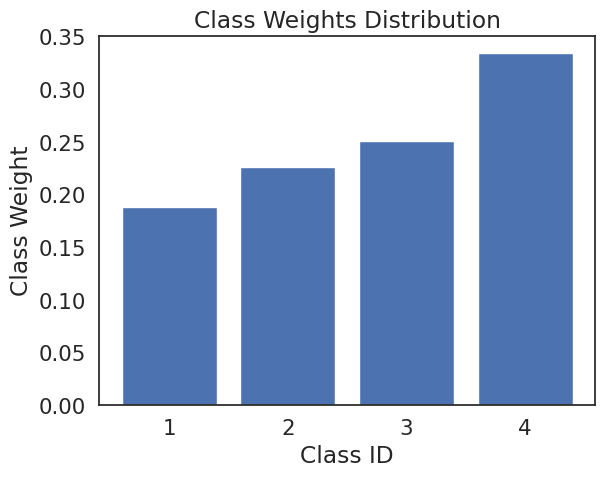

In [ ]:
# Funzione per calcolare i pesi delle classi come percentuali
def calculate_class_weights(X_train, y_train, exponent=2):
    class_counts = Counter()  # Contatore per il numero di occorrenze per ciascuna classe
    total_pixels = 0  # Numero totale di pixel in tutto il dataset

    # Itera su ogni immagine nel dataset
    for i in range(X_train.shape[0]):
        mask = y_train[i]  # Ottieni la maschera di classe per l'immagine
        unique_classes = np.unique(mask)  # Trova tutte le classi uniche (eccetto la classe di background, 0)

        # Per ogni classe presente nell'immagine
        for class_id in unique_classes:
            if class_id == 0:  # Ignora la classe di background (0)
                continue
            # Conta il numero di pixel per classe
            class_counts[class_id] += np.sum(mask == class_id)
            total_pixels += mask.size  # Aggiungi il numero di pixel di questa immagine

    # Creare un dizionario dei pesi per ciascuna classe
    class_weights = []

    # Calcolare il peso delle classi come inversamente proporzionale al numero di occorrenze
    for class_id in range(1, max(class_counts.keys()) + 1):  # Itera su tutte le classi (ignorando lo sfondo)
        class_pixel_count = class_counts.get(class_id, 1)  # Default a 1 se la classe non è presente
        # Calcolare il peso come inversamente proporzionale alla frequenza della classe
        class_weight = (1 - (class_pixel_count / total_pixels)) ** exponent
        class_weights.append(class_weight)

    # Normalizzare i pesi in modo che sommino a 1
    weight_sum = sum(class_weights)
    class_weights = [weight / weight_sum for weight in class_weights]

    return class_weights

# Esempio di utilizzo:
# X_train = np.array([...])  # Immagini in bianco e nero (N, H, W)
# y_train = np.array([...])  # Etichette dei pixel (N, H, W)
class_weights = calculate_class_weights(X_train, y_train, exponent=2)

# Stampa i pesi delle classi in formato array (0: peso, 1: peso, ...)
print(class_weights)

# Grafico per visualizzare la distribuzione dei pesi
plt.bar(range(1, len(class_weights) + 1), class_weights)
plt.xlabel('Class ID')
plt.ylabel('Class Weight')
plt.title('Class Weights Distribution')
plt.show()

In [ ]:
# Funzione di loss pesata
def weighted_loss(class_weights):
    def loss(y_true, y_pred):
        # Converti class_weights in un tensore
        weights = tf.constant(class_weights, dtype=tf.float32)

        # Assicurati che y_true sia un intero
        y_true = tf.cast(y_true, dtype=tf.int32)

        # Calcola la perdita base (senza pesi)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        # Calcola i pesi per ogni classe (moltiplicando per il valore corrispondente)
        pixel_weights = tf.gather(weights, y_true)

        # Applica i pesi alla perdita
        weighted_loss = loss * pixel_weights

        # Restituisci la perdita media
        return tf.reduce_mean(weighted_loss)

    return loss

In [ ]:
# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

loss_function = weighted_loss(class_weights)

model.compile(optimizer="adam", loss=loss_function, metrics=[mean_iou])